## Torch Imports

In [1]:
# # install neccessary packages
# !pip install segmentation-models-pytorch
# !pip install pytorch-msssim
# !pip install kornia
# !pip install torchsummary
# !pip install pytorch-lightning

In [2]:
# Ml package Inports
import torch
from torch import nn
from torch import optim

import torchvision
from torchvision import transforms
from torchvision import models
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Dataset

from torchsummary import summary

from torch.nn import functional as F

import pytorch_lightning as pl

## Helper Imports

In [3]:
# Helper package Imports
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from pytorch_msssim import SSIM, MS_SSIM, ssim, ms_ssim
from zipfile import ZipFile
import os
from PIL import Image, ImageOps
from pathlib import Path
import shutil
import time
from tqdm.notebook import tqdm, trange
from kornia.color import rgb_to_lab, bgr_to_rgb, lab_to_rgb
from kornia.utils import image_to_tensor
%matplotlib inline

## Image Dimension and Batch Size

In [4]:
img_dim = 256
batch_size = 12

## Data Extract

In [5]:
# Directories
data_path = "D:/Data/"

In [6]:
# Extracting Dataset and renameing folder
if not Path(data_path).is_dir():
    !pip install kaggle
    !kaggle datasets download -d mariomatos/image-colorization
    
    # Extract Data From Zip File
    with ZipFile('image-colorization.zip',"r") as z:
        z.extractall(path = data_path)
    old_path = data_path + str(os.listdir(data_path)[0])
    
    image_paths = [f'{old_path}/{img}' for img in os.listdir(old_path)]
    
    # Change Data Directory to ./Data/...
    print("Changing Image Directory >>")
    for i in trange(len(image_paths)):
        shutil.move(image_paths[i], data_path)
    
    os.rmdir(old_path)
    image_paths = [f'{data_path}{img}' for img in os.listdir(data_path)]
    print(f"Total Images Ectracted from the Dataset\t\t: {len(image_paths)}")
    
    # Remove Grayscale Images
    print("Removing Grayscale Images >>")
    for i in trange(len(image_paths)):
        img = cv2.imread(image_paths[i])
        img = torch.from_numpy(img).permute(2,0,1)        
        
        if torch.mean(((img[0] == img[1]) == (img[1] == img[2])).float()) == 1:
            os.remove(image_paths[i])
    
    print(f"Total Images after Removing Grayscale Images\t: {len(os.listdir(data_path))}")

## Data Sample

In [7]:
# filename check
imgs = os.listdir(data_path)
print(f'Total Images : {len(imgs)}')
print(f'Sample Image Name : {imgs[random.randint(0, len(imgs))]}')

Total Images : 10504
Sample Image Name : 000000224016.jpg


## Helper Methods

In [8]:
def ab_Norm(ab_x):
    ab = torch.clone(ab_x)
    ab = ab * 128
    return ab.long()

def ab_UnNorm(ab_x):
    ab = torch.clone(ab_x)
    ab = ab / 128
    return ab.float()

def l_Norm(l_x):
    l = torch.clone(l_x)
    l = (l * 100) + 50
    return l.long()

def l_UnNorm(l_x):
    l = torch.clone(l_x)
    l = (l - 50) / 100
    return l.float()

def fullImg(inp, tar):
    return torch.cat((inp, tar), 0)

def getRGB(img):
    x = torch.clone(img)
    x[0] = (x[0] * 100) + 50
    x[1:] = x[1:] * 128
    return (lab_to_rgb(x) * 255).long() 

def getLABs(img):
    x = torch.clone(img)
    x[0:, 0, 0:, 0:] = (x[0:, 0, 0:, 0:] * 100) + 50
    x[0:, 1:, 0:, 0:] = x[0:, 1:, 0:, 0:] * 128
    return x

def getRGBs(img):
    x = torch.clone(img)
    x[0:, 0, 0:, 0:] = (x[0:, 0, 0:, 0:] * 100) + 50
    x[0:, 1:, 0:, 0:] = x[0:, 1:, 0:, 0:] * 128
    return (lab_to_rgb(x) * 255).float()

## Building Dataset

In [9]:
# create dataset
class DatasetBNW(Dataset):
    def __init__(self, path=data_path, transform=None):
        self.data = [f'{path}{img}' for img in os.listdir(path)]
        self.length = len(self.data)
        self.transform = transform

    def __getitem__(self, index):
        img = cv2.imread(self.data[index])
        img = cv2.resize(img, (img_dim, img_dim))
        
        img = image_to_tensor(img)
        
        img = bgr_to_rgb(img) / 255
        img = rgb_to_lab(img)
    
        input_img = img[0,0:,0:].view(1,img_dim,img_dim)
        input_img = l_UnNorm(input_img)
        
        target_img = img[1:,0:,0:]
        target_img = ab_UnNorm(target_img)
        
        return input_img, target_img
    
    def __len__(self):
        return len(self.data)

In [10]:
dataset = DatasetBNW()

## Sample Dataset Image

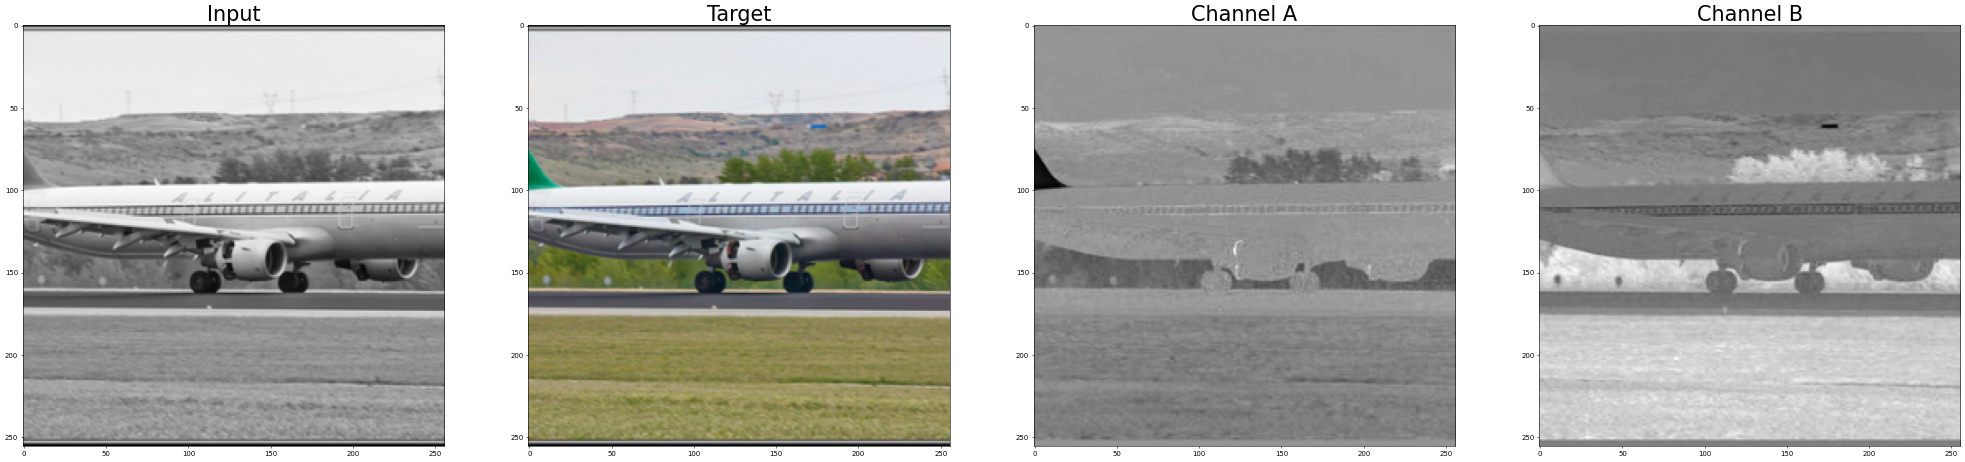

In [11]:
inp, tar = dataset[random.randint(0, len(dataset))]
f = fullImg(inp, tar)
full = getRGB(f)

plt.figure(figsize=(50,50), dpi=50)

plt.subplot(241)
plt.title('Input', fontdict = {'fontsize': 30})
plt.imshow(inp.permute(1,2,0), cmap = 'gray')

plt.subplot(242)
plt.title('Target', fontdict = {'fontsize': 30})
plt.imshow(full.permute(1,2,0), cmap = 'gray')

plt.subplot(243)
plt.title('Channel A', fontdict = {'fontsize': 30})
plt.imshow(tar[0,0:,0:].view(1,img_dim,img_dim).permute(1,2,0), cmap = 'gray')

plt.subplot(244)
plt.title('Channel B', fontdict = {'fontsize': 30})
plt.imshow(tar[1,0:,0:].view(1,img_dim,img_dim).permute(1,2,0), cmap = 'gray')

## DataLoaders

In [12]:
# split data into train, validation and test data
def split_indices(n, val_pct, test_pct, seed=65):
    # determine the size of the validation set, test set
    n_val = int(val_pct*n)
    n_test = int(test_pct*n + n_val)
    # print(n_val, n_test, n_train)
    # create random parmutation of 0 to n-1
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    # pick data as train[start-val], validation[val-test] and test[test-end]
    return idxs[n_test:], idxs[:n_val], idxs[n_val:n_test]

In [13]:
# split the dataset into training, validation and test set
train_indices, val_indices, test_indices = split_indices(len(dataset), 0.2, 0.1)
print(f"""
        Training Images   : {len(train_indices)}\n
        Validation Images : {len(val_indices)}\n
        Testing Images    : {len(test_indices)}\n
        Total Images      : {len(train_indices) + len(val_indices) + len(test_indices)}""")


        Training Images   : 7354

        Validation Images : 2100

        Testing Images    : 1050

        Total Images      : 10504


In [14]:
# training sampler and dataloader
train_sampler = SubsetRandomSampler(train_indices)    # takes samples w.r.t the indices
# train_dl = DataLoader(dataset,
#                       batch_size,
#                       sampler = train_sampler)

In [15]:
# validation sampler and dataloader
val_sampler = SubsetRandomSampler(val_indices)        # takes samples w.r.t the indices
# val_dl = DataLoader(dataset,
#                     batch_size,
#                     sampler = val_sampler)

In [16]:
# test sampler and dataloader
test_sampler = SubsetRandomSampler(test_indices)        # takes samples w.r.t the indices
# test_dl = DataLoader(dataset,
#                      batch_size,
#                      sampler = test_sampler)

## Show and Print Result

In [17]:
def pltSubpot(cord, pos, cp, title, pic, titleShow = True):
    plt.subplot2grid(cord, pos, colspan=cp)
    plt.axis('off')
    if titleShow:
        plt.title(title, fontdict = {'fontsize': 20})    
    plt.imshow(pic, cmap = plt.cm.gray)

In [18]:
def testResult(t_model, idx = None, savePath = None, name = None, show = True, device = 'cuda'):
    if idx == None:
        inp, tgt = dataset[(random.choices(list(test_sampler.indices))[0])]
    else:
        inp, tgt = dataset[list(test_sampler.indices)[idx]]
    
    out = t_model.predictCI(inp.unsqueeze(0).)
    out = out.squeeze(0).cpu()
    
    target = fullImg(inp, tgt)
    
    if not Path(f'{savePath}').is_dir():
        Path.mkdir(Path(f'{savePath}'))
        
    fig = plt.figure(figsize=(25,25), dpi=45)
    
    graph_dim = (3, 6)
    
    # input
    pltSubpot(graph_dim, (0, 0), 2, 'Input', inp.permute(1,2,0))
    
    # target
    pltSubpot(graph_dim, (0, 2), 2, 'Target', getRGB(target).permute(1,2,0))
    
    # output
    pltSubpot(graph_dim, (0, 4), 2, 'Output', getRGB(out).permute(1,2,0))
    
    if name != None:
        # target L
        pltSubpot(graph_dim, (1, 0), 2, 'target L Channel', target[0,0:,0:].cpu())

        # target A
        pltSubpot(graph_dim, (1, 2), 2, 'target A Channel', target[1,0:,0:].cpu())

        # target B
        pltSubpot(graph_dim, (1, 4), 2, 'target B Channel', target[2,0:,0:].cpu())

        # output L
        pltSubpot(graph_dim, (2, 0), 2, 'Output L Channel', out[0,0:,0:].cpu().detach())

        # output A
        pltSubpot(graph_dim, (2, 2), 2, 'Output A Channel', out[1,0:,0:].cpu().detach())

        # output B
        pltSubpot(graph_dim, (2, 4), 2, 'Output B Channel', out[2,0:,0:].cpu().detach())        
        
    else:
        # target L
        pltSubpot(graph_dim, (1, 0), 1, 'target L Channel', target[0,0:,0:].cpu())

        # target A
        pltSubpot(graph_dim, (1, 1), 1, 'target A Channel', target[1,0:,0:].cpu())

        # target B
        pltSubpot(graph_dim, (1, 2), 1, 'target B Channel', target[2,0:,0:].cpu())

        # output L
        pltSubpot(graph_dim, (1, 3), 1, 'Output L Channel', out[0,0:,0:].cpu().detach())

        # output A
        pltSubpot(graph_dim, (1, 4), 1, 'Output A Channel', out[1,0:,0:].cpu().detach())

        # output B
        pltSubpot(graph_dim, (1, 5), 1, 'Output B Channel', out[2,0:,0:].cpu().detach())
        
        # Validation Loss Graph
        plt.subplot2grid(graph_dim, (2, 0), colspan=3)
        plt.plot(val_accuracies, label = 'Validation Accuracy')
        plt.xlabel('Epoch', fontdict = {'fontsize': 15})
        plt.title('Accuracy', fontdict = {'fontsize': 20})
        plt.legend(fontsize='x-large')

        # Validation Loss Graph
        plt.subplot2grid(graph_dim, (2, 3), colspan=3)
        plt.plot(val_losses, label = 'Validation Loss')
        plt.xlabel('Epoch', fontdict = {'fontsize': 15})
        plt.title('Loss', fontdict = {'fontsize': 20})
        plt.legend(fontsize='x-large')
    
    plt.tight_layout()
    
    if savePath != None:
        if name == None:
            plt.savefig(f'{savePath}/result.jpg')
        else:
            plt.savefig(f'{savePath}/{name}.jpg')
    
    if not show:
        plt.close(fig)
        print('Plot Saved')

In [19]:
def modelSampleOut(t_model, idx = [1,2,3,4,5], savePath = None, saveTarget = False, result = None, show = False, realLife = None, device = 'cuda'):
    if realLife == None:
        inp_list = tuple([dataset[list(test_sampler.indices)[j]][0] for j in idx])
        inp_list = torch.stack(inp_list)
    else:
        inp_list = realLife
    
    if saveTarget:
        inp = tuple([dataset[list(test_sampler.indices)[j]][0] for j in idx])
        inp = torch.stack(inp)
        
        tgt = tuple([dataset[list(test_sampler.indices)[j]][1] for j in idx])
        tgt = torch.stack(tgt)
        
        out = torch.cat((inp, tgt), 1)
    else:
        out = t_model.predictCI(inp_list)
        out = out.cpu()
        
    
    fig = plt.figure(figsize=(35,5), dpi=45)
    
    graph_dim = (1, 7)
    
    if not Path(f'{savePath}').is_dir():
        Path.mkdir(Path(f'{savePath}'))
    
    if not saveTarget:
        # Model Info Label
        plt.subplot2grid(graph_dim, (0, 0), colspan=1)
        if result != None:
            plt.text(.3, .5, 
                     modelInfo(2, ['Test Loss', 'Test Accuracy']), 
                     dict(size=25),  
                     verticalalignment='center')
        else:
            plt.text(.3, .5, 
                     modelInfo(2), 
                     dict(size=25),  
                     verticalalignment='center')
        plt.axis('off')

        # Model Info Label
        plt.subplot2grid(graph_dim, (0, 1), colspan=1)
        if result != None:
            plt.text(.3, .5, 
                     modelInfo(3, result), 
                     dict(size=25),  
                     verticalalignment='center')
        else:
            plt.text(.3, .5, 
                     modelInfo(3), 
                     dict(size=25),  
                     verticalalignment='center')
        plt.axis('off')
    else:
        plt.subplot2grid(graph_dim, (0, 0), colspan=2)
        plt.text(0.5, 0.5, 
                 "Target Images", 
                 dict(size=25),
                 horizontalalignment='center',
                 verticalalignment='center')
        plt.axis('off')
    
    # sample 1
    pltSubpot(graph_dim, (0, 2), 1, 'Sample 1', getRGB(out[0]).permute(1,2,0), titleShow=False)
    
    # sample 2
    pltSubpot(graph_dim, (0, 3), 1, 'Sample 2', getRGB(out[1]).permute(1,2,0), titleShow=False)
    
    # sample 3
    pltSubpot(graph_dim, (0, 4), 1, 'Sample 3', getRGB(out[2]).permute(1,2,0), titleShow=False)
    
    # sample 4
    pltSubpot(graph_dim, (0, 5), 1, 'Sample 4', getRGB(out[3]).permute(1,2,0), titleShow=False)
    
    # sample 5
    pltSubpot(graph_dim, (0, 6), 1, 'Sample 5', getRGB(out[4]).permute(1,2,0), titleShow=False)
    
    plt.tight_layout(pad=1.0, h_pad=1.0)
    
    if realLife != None:
        outputFile = 'RealOut'
    else:
        outputFile = 'SampleOutputs'
        
    if saveTarget:
        plt.savefig(f'{savePath}/Targets.jpg')
    else:
        plt.savefig(f'{savePath}/{outputFile}.jpg')
    
    if not show:
        plt.close(fig)
        print('Plot Saved')

In [20]:
def samplesOut(t_model, idx = [1,2,3,4,5], savePath = None, saveTarget = False, show = False, grayScale = False, realLife = None, device = 'cuda'):
    if realLife == None:
        inp_list = tuple([dataset[list(test_sampler.indices)[j]][0] for j in idx])
        inp_list = torch.stack(inp_list)
    else:
        inp_list = realLife
    
    if saveTarget:
        inp = tuple([dataset[list(test_sampler.indices)[j]][0] for j in idx])
        inp = torch.stack(inp)
        
        tgt = tuple([dataset[list(test_sampler.indices)[j]][1] for j in idx])
        tgt = torch.stack(tgt)
        
        out = torch.cat((inp, tgt), 1)
    else:
        out = t_model.predictCI(inp_list)
        out = out.cpu()
    
    if not Path(f'{savePath}').is_dir():
        Path.mkdir(Path(f'{savePath}'))
    
    if not Path(f'./TargetSample').is_dir():
        Path.mkdir(Path(f'./TargetSample'))
    
    if not Path(f'./InputSample').is_dir():
        Path.mkdir(Path(f'./InputSample'))
    
    if grayScale:
        for i, inpt in enumerate(inp_list):
            fig = plt.figure(figsize=(10, 10), dpi=45)

            graph_dim = (1, 1)

            # sample 1
            pltSubpot(graph_dim, (0, 0), 1, '', inpt.permute(1,2,0), titleShow=False)

            plt.tight_layout(pad=1.0, h_pad=1.0)  
            
            if realLife == None:
                plt.savefig(f'./InputSample/G{i+1}.jpg')
            else:
                plt.savefig(f'./RealTest/{i+1}.jpg')
                
            if not show:
                plt.close(fig)
                print('Plot Saved')
    else:
        for i, o in enumerate(out):
            fig = plt.figure(figsize=(10, 10), dpi=45)

            graph_dim = (1, 1)

            # sample 1
            pltSubpot(graph_dim, (0, 0), 1, '', getRGB(o).permute(1,2,0), titleShow=False)

            plt.tight_layout(pad=1.0, h_pad=1.0)  
            
            if realLife != None:
                fn = 'R'
            else:
                fn = 'S'
                
            if saveTarget:
                plt.savefig(f'./TargetSample/T{i+1}.jpg')
            else:
                plt.savefig(f'{savePath}/{fn}{i+1}.jpg')

            if not show:
                plt.close(fig)
                print('Plot Saved')

## Device

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Model Specification

In [22]:
def modelInfo(choice = 1, result = None):
    info = ''
    if choice == 1:
        info = f"Architecture\t: {arch}\nEncoder\t\t: {encoder}\nLoss in ColorSpace\t: {colorsspace}\nLoss Function\t: {loss_fn}\nEmbedding\t: {embedding}\nEncoder Weights\t: {enc_wei}"
        return 
    elif choice == 2:
        info = f"Architecture\nEncoder\nLoss in ColorSpace\nLoss Function\nEmbedding\nEncoder Weights"
        if result != None:
            for i in result:
                info = info+f'\n{i}'
    else:
        info = f": {arch}\n: {encoder}\n: {colorsspace}\n: {loss_fn}\n: {embedding}\n: {enc_wei}"
        if result != None:
            for i in result:
                info = info+f'\n: {i}'
    
    return info

In [23]:
def specFromName(name):
    spec = name.split('_')
    return [spec[0], spec[1].lower(), spec[2], spec[3], spec[4].lower(), spec[5].lower()]

In [24]:
model_dir = './Saved/'
if Path(model_dir).is_dir():
    model_data_folders = os.listdir(model_dir)

In [26]:
specs = {}

if Path(model_dir).is_dir() and len(model_data_folders) > 0:
    print('Choose a Model >>\n')
    for i, md in enumerate(model_data_folders):
        print(f'{(i+1):2d}. {md}')
    
    print(f'{(len(model_data_folders)+1):2d}. Add New Model')

    user_choice = True
    if user_choice:
        md_in = int(input('Choice: '))
    else:
        md_in = int(5)
    
    if md_in < len(model_data_folders)+1:
        model_data = model_data_folders[md_in-1]
        arch, encoder, colorsspace, loss_fn, embedding, enc_wei = specFromName(model_data)
    else:
        print('Add a Model >>\n')
        arch = str(input('Architecture: ')).capitalize()
        encoder = str(input('Encoder: ')).capitalize()
        colorsspace = str(input('Color Space: ')).upper()
        loss_fn = str(input('Loss Function: ')).upper()
        embedding = str(input('Embedding: ')).capitalize()
        enc_wei = str(input('Encoder Weights: ')).capitalize()

    specs = {'arch' : arch,
             'encoder' : encoder,
             'colorsspace' : colorsspace,
             'loss_fn' : loss_fn,
             'embedding' : embedding,
             'enc_wei' : enc_wei,
            }
else:
    print('Add a Model >>\n')
    specs['arch'] = str(input('Architecture: ')).capitalize()
    specs['encoder'] = str(input('Encoder: ')).capitalize()
    specs['colorsspace'] = str(input('Color Space: ')).upper()
    specs['loss_fn'] = str(input('Loss Function: ')).upper()
    specs['embedding'] = str(input('Embedding: ')).capitalize()
    specs['enc_wei'] = str(input('Encoder Weights: ')).capitalize()

print(specs)

Choose a Model >>

 1. Unet++_Resnet18_LAB_MS-SSIM_None_Imagenet
 2. Unet++_Resnet34_RGB_FMID64_Resnet101_Imagenet
 3. Add New Model
Choice: 2
{'arch': 'Unet++', 'encoder': 'resnet34', 'colorsspace': 'RGB', 'loss_fn': 'FMID64', 'embedding': 'resnet101', 'enc_wei': 'imagenet'}


## Save and Load Model Data

In [27]:
# Loading previous losses and accuracies
def loadModelData(directory='./Saved/'):
    acc = []
    los = []
    modelData = None
    if not Path('./Saved').is_dir():
        Path.mkdir(Path('./Saved'))
        
    if Path(directory).is_dir():
        if os.path.exists(f'{directory}/modelParams.pth'):
            # model.load_state_dict()
            modelData = torch.load(f'{directory}/modelParams.pth')
    else:
        Path.mkdir(Path(directory))
        
    try:
        with open(f'{directory}/accuracies.txt', 'r') as fd:
            acc = [float(acc.rstrip()) for acc in fd.readlines()]

        with open(f'{directory}/losses.txt', 'r') as fd:
            los = [float(losses.rstrip()) for losses in fd.readlines()]
    except IOError:
        print('file not Found')
    
    return modelData, acc, los

In [28]:
# save the model parameters to the disk
def saveModelData(model, directory='./Saved/', valScore = None, testScore = None):
    torch.save(model.state_dict(), f'{directory}/modelParams.pth')
#     model.save_hyperparameters()
    
    if testScore != None:
        with open(f'{directory}/testScore.txt', 'w') as fd:
                fd.write(f"Accuracy : {testScore['acc']:.10f}\nLoss : {testScore['loss']:.10f}\n")
    
    if valScore != None:
        with open(f'{directory}/accuracies.txt', 'a') as fd:
                fd.write(f"{valScore['acc']:.10f}\n")

        with open(f'{directory}/losses.txt', 'a') as fd:
            fd.write(f"{valScore['loss']:.10f}\n") 

## ColorNet Model

In [29]:
class ColorNet(pl.LightningModule):
    def __init__(self, dataset, modelDir, batch_size = 8, specs = {}, alpha = 1.4, beta = 1.6):
        super(ColorNet, self).__init__()
        self.modelDir = modelDir
        self.specs = specs
        self.dataset = dataset
        self.train_indices, self.val_indices, self.test_indices = split_indices(len(self.dataset), 0.2, 0.1)
        self.batch_size = batch_size
        self.ms_ssim = MS_SSIM(data_range=255, size_average=True, channel=3)
        self.mse = nn.MSELoss()
        
        self.lr = 1e-6

        self.alpha = alpha
        self.beta = beta
        
        if 'net++' in self.specs['arch'].lower():
            self.net = smp.UnetPlusPlus(
                encoder_name = self.specs['encoder'].lower(),
                encoder_weights = self.specs['enc_wei'].lower(),
                in_channels = 1,
                classes = 2,
                activation = None,
            )
        else:
            self.net = smp.Unet(
                encoder_name = self.specs['encoder'].lower(),
                encoder_weights = self.specs['enc_wei'].lower(),
                in_channels = 1,
                classes = 2,
                activation = None,
            )  
        
        self.activation = nn.Sequential(      
            nn.Tanh(),
        )

        if self.specs['embedding'].lower() == 'resnet18':
            self.embnet = models.resnet18(pretrained = True, progress=True)
        elif self.specs['embedding'].lower() == 'resnet34':
            self.embnet = models.resnet34(pretrained = True, progress=True)
        elif self.specs['embedding'].lower() == 'resnet50':
            self.embnet = models.resnet50(pretrained = True, progress=True)
        elif self.specs['embedding'].lower() == 'resnet101':
            self.embnet = models.resnet101(pretrained = True, progress=True)
        elif self.specs['embedding'].lower() == 'resnet152':
            self.embnet = models.resnet152(pretrained = True, progress=True)
        elif self.specs['embedding'].lower() == 'vgg16':
            self.embnet = models.vgg16(pretrained = True, progress=True)
        elif self.specs['embedding'].lower() == 'vgg19':
            self.embnet = models.vgg19(pretrained = True, progress=True)
        else:
            self.embnet = None
        
        if self.embnet != None:
            for param in self.embnet.parameters():
                param.requires_grad = False
        
    def forward(self, x):        
        out = self.net(x)        
        out = self.activation(out)

        return out
    
    def predictCI(self, x):
        self.freeze()
        out = self(x)        
        out = torch.cat((x, out), 1)
        self.unfreeze()
        
        return out

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = self.lr)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        inputs, targets = batch

        # forward pass
        predictions = self(inputs)
        
        # Lab
        pred = torch.cat((inputs, predictions), 1)
        targ = torch.cat((inputs, targets), 1)

        
        # loss calculation
        J = self.__getLoss(pred, targ)
        
        acc = self.ms_ssim(getRGBs(pred), getRGBs(targ))

        pbar = {'train_acc' : acc}
        return {'loss' : J, 'progress_bar' : pbar}
    
    def validation_step(self, batch, batch_idx):
        results = self.training_step(batch, batch_idx)
        results['progress_bar']['val_acc'] = results['progress_bar']['train_acc']
        del results['progress_bar']['train_acc']
        return results
    
    def test_step(self, batch, batch_idx):
        results = self.validation_step(batch, batch_idx)
        results['progress_bar']['test_acc'] = results['progress_bar']['val_acc']
        del results['progress_bar']['val_acc']
        return results
    
    def validation_epoch_end(self, val_step_outputs):
        avg_val_loss = torch.tensor([x['loss'] for x in val_step_outputs]).mean()
        avg_val_acc = torch.tensor([x['progress_bar']['val_acc'] for x in val_step_outputs]).mean()
        
        saveModelData(self, directory = self.modelDir, valScore = {'loss': avg_val_loss, 'acc': avg_val_acc})
        
        self.log_dict({'val_loss': avg_val_loss, 'val_acc': avg_val_acc})
        
        pbar = {'avg_val_acc' : avg_val_acc}
        return {'val_loss' : avg_val_loss, 'progress_bar' : pbar}
    
    def test_epoch_end(self, test_step_outputs):
        avg_test_loss = torch.tensor([x['loss'] for x in test_step_outputs]).mean()
        avg_test_acc = torch.tensor([x['progress_bar']['test_acc'] for x in test_step_outputs]).mean()
        
        saveModelData(self, directory = self.modelDir, testScore = {'loss': avg_test_loss, 'acc': avg_test_acc})
        
        self.log_dict({'test_loss': avg_test_loss, 'test_acc': avg_test_acc})
        
        pbar = {'avg_test_acc' : avg_test_acc}
        return {'test_loss' : avg_test_loss, 'progress_bar' : pbar}
        
    
    def train_dataloader(self):
        # training sampler and dataloader
        train_sampler = SubsetRandomSampler(self.train_indices)    # takes samples w.r.t the indices
        train_dl = DataLoader(self.dataset,
                              self.batch_size,
                              sampler = train_sampler)
        return train_dl
    
    def val_dataloader(self):
        # validation sampler and dataloader
        val_sampler = SubsetRandomSampler(self.val_indices)        # takes samples w.r.t the indices
        val_dl = DataLoader(self.dataset,
                            self.batch_size,
                            sampler = val_sampler)
        return val_dl
    
    def test_dataloader(self):
        # test sampler and dataloader
        test_sampler = SubsetRandomSampler(self.test_indices)        # takes samples w.r.t the indices
        test_dl = DataLoader(self.dataset,
                             self.batch_size,
                             sampler = test_sampler)
        return test_dl

    def __featureMapMSSSIMLoss(self, preds, targs):

        predRGB = getRGBs(preds)
        targRGB = getRGBs(targs)
        fmloss = 1 - self.__featureMapLoss(predRGB, targRGB)
        msloss = 1 - self.ms_ssim(predRGB, targRGB)

        loss = (self.alpha * msloss) + (self.beta * fmloss)
        return loss
    
    def __featureMapLoss(self, preds, targs):
        # resnet embedding
        emb = self.specs['embedding'].lower()
        lossfn = self.specs['loss_fn'].lower()        
        
        #feature map with dimension 16x16
        if '16' in lossfn:
            embednet = nn.Sequential(*list(self.embnet.children())[:-3])
            winSize = 1
            
        #feature map with dimension 32x32
        elif '32' in lossfn:
            embednet = nn.Sequential(*list(self.embnet.children())[:-4])
            winSize = ((32 / (2**4)) + 1) - 2
            
        #feature map with dimension 64x64
        elif '64' in lossfn:
            embednet = nn.Sequential(*list(self.embnet.children())[:-5])
            winSize = ((64 / (2**4)) + 1) - 2
        
        #feature map with dimension 128x128
        elif '128' in lossfn:
            embednet = nn.Sequential(*list(self.embnet.children())[:-7])
            winSize = ((128 / (2**4)) + 1) - 2

        #feature map with dimension >= 256x256
        else:
            embednet = nn.Sequential(*list(self.embnet.children())[:-7])
            winSize = 11
        
        preds = embednet(preds)
        targs = embednet(targs)
        FMLoss = SSIM(data_range=255, size_average=True, channel=preds.shape[1], win_size = winSize)
        
        return FMLoss(preds, targs)
    
    def __getLoss(self, pred, targ):
        loss = 0

        if self.specs['colorsspace'].lower() == 'lab':
            preds = getLABs(pred)
            targs = getLABs(targ)
        else:
            preds = getRGBs(pred)
            targs = getRGBs(targ)
            
        #Loss Calculation
        if 'fmid' in self.specs['loss_fn'].lower():
            loss = self.__featureMapMSSSIMLoss(preds, targs)
            
        elif self.specs['loss_fn'].lower() == 'ms-ssim':
            loss = 1 - self.ms_ssim(preds, targs)

        elif self.specs['loss_fn'].lower() == 'mse':
            if self.embnet == None:
                loss = self.mse(preds, targs) / 255            
            else:
                embednet = nn.Sequential(*list(self.embnet.children())[:-2])
                loss = self.mse(torch.tanh(embednet(preds)), torch.tanh(embednet(targs)))
                
        elif self.specs['loss_fn'].lower() == 'mse+ms-ssim':        
            loss1 = 1 - self.ms_ssim(preds, targs)
            loss2 = 0
            if self.embnet == None:
                loss2 = self.mse(preds, targs) / 255            
            else:
                embednet = nn.Sequential(*list(self.embnet.children())[:-2])
                loss2 = self.mse(torch.tanh(embednet(preds)), torch.tanh(embednet(targs)))

            loss = (loss1 + loss2) * 0.5
            
        else:
            loss = 1 - self.ms_ssim(preds, targs)

        return loss

## Model Intialization

In [30]:
torch.backends.cudnn.enabled = True

In [31]:
# Model_Arc-Encoder-ColorSpace-Loss-Embedding.pth'
model_save_file = "_".join([specs[x] for x in specs])
model_dir_name = f'./Saved/{model_save_file}'

model = ColorNet(dataset, modelDir = model_dir_name, specs = specs).to(device)

modelData, val_accuracies, val_losses = loadModelData(directory=model_dir_name)

if modelData != None:
    model.load_state_dict(modelData)

In [32]:
# trainer = pl.Trainer(auto_lr_find=True, progress_bar_refresh_rate = 1, max_epochs = 5, gpus = 1)

In [33]:
# trainer.tune(model)

In [34]:
# trainer.fit(model)

In [35]:
# result = trainer.test(model)
# print(result)

In [36]:
# trainer = pl.Trainer(progress_bar_refresh_rate = 1, max_epochs = 5, gpus = 1)

# # Run learning rate finder
# lr_finder = trainer.tuner.lr_find(model)

# # Results can be found in
# lr_finder.results

# # Plot with
# fig = lr_finder.plot(suggest=True)
# fig.show()

# # Pick point based on plot, or get suggestion
# new_lr = lr_finder.suggestion()

In [37]:
saveModelData(model, directory=model_dir_name)

In [38]:
testResult(model, 25, f'{model_dir_name}/Results')

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
img_idx = [1, 10, 25, 28, 42]
modelSampleOut(model, img_idx, f'{model_dir_name}/Results', saveTarget = False, show = True)

In [ ]:
samplesOut(model, img_idx, f'{model_dir_name}/Results', saveTarget = False, show = False)

In [ ]:
testDir = './RealTest/'
testImg = os.listdir(testDir)
img_dim = 256

In [ ]:
testImgs = []
for ti in testImg:
    timg = cv2.imread(f'{testDir}{ti}')
    timg = cv2.resize(timg, (img_dim, img_dim))
    timg = torch.from_numpy(timg).permute(2,0,1) / 255 - .5
    testImgs.append(timg[0].unsqueeze(0))

In [ ]:
testImgs = torch.stack(tuple(testImgs))

In [ ]:
fig = plt.subplots(1, 5, figsize=(50, 10), dpi=45)
graph_dim = (1, 5)

for i, ti in enumerate(testImgs):
    pltSubpot(graph_dim, (0, i), 1, '', ti.permute(1,2,0), titleShow=False)

In [ ]:
modelSampleOut(model, img_idx, f'{model_dir_name}/Results', saveTarget = False, show = True, realLife = testImgs)

In [ ]:
samplesOut(model, img_idx, f'{model_dir_name}/Results', saveTarget = False, show = False, realLife = testImgs)